# Transformers

## Encoder-Decoder Transformers

Neste notebook, iremos trabalhar e entender um pouco mais dos componentes essencias que compõem a parte de *decoder* de um* Transformers*, além de utilizar a arquitetura completa para realizar a previsão de litologia de perfis de poço (séries temporais).

### Revisão rápida dos conceitos da última aula

O mecanismo de atenção utilizado por um *Transformers* se dá através do processo chamado de *scaled dot-product*, tendo a seguinte fórmula:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Softmax}\left[\dfrac{\mathbf{Q}\mathbf{K^T}}{\text{d_model}}\right] \mathbf{V}
$$

Além disso, é proposto um aprimoramento desse conceito de atenção através do uso de múltiplas **cabeças de atenção**, um análogo ao uso de múltiplos filtros convolucionais em uma camada convolucional de uma rede CNN.

$$
\text{MHA}(Q, K, V) = \text{concat}\left[H_1, \dots, H_n\right]\mathbf{W^{(o)}} \text{ , onde } H_i = Attention(Q\mathbf{W^{(q)}_i}, K\mathbf{W^{(k)}_i}, V\mathbf{W^{(v)}_i})
$$

O mecanismo de atenção MHA é usado em diversas regiões do nosso transformer, tanto no *encoder* quanto no *decoder*. Durante o *encoder*, utilizamos o que é chamado de **self-attention**, formulado por $\text{MHA}(X, X, X)$. Já no *decoder* utilizamos um **masked self-attention**, que opera identicamente ao **self-attention** visto anteriormente, porém agora multiplicamos a atenção por uma máscara binária, suprimindo algumas entradas da matriz de atenção; bem como um **cross-attention**, onde temos a formulação $\text{MHA}(Q, K, V)$ usual, onde $Q$ é informado pelo *decoder* e $K, V$ pelo *encoder*.

A partir da imagem a seguir, podemos observar a relação e utilidade desses diversos blocos ao longo de um *Transformers*:

<div style="text-align: center;">
    <img width=400 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/transformers.png?raw=true"/>
</div>

Como fazemos tudo isso em PyTorch? Utilizamos o módulo `nn.Transformer`, cuja documentação pode ser acessada [aqui](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)!

> Manipulando as máscaras de atenção do *encoder* e *decoder*, podemos adaptar esse módulo para suportar diversas tarefas relacionadas com sequência (*many-to-one*, *one-to-many*, *many-to-many*), respeitando ou não a sequencialidade e o viés temporal da entrada.

- **Importante:** Note que a camada de *Positional Encoding* e *Embedding* não fazem parte do módulo!

In [ ]:
import torch
import torch.nn as nn

transformer = nn.Transformer(d_model=512, nhead=8, dim_feedforward=2048, activation='gelu',
                             num_encoder_layers=1, num_decoder_layers=1, batch_first=True)

transformer

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=

In [ ]:
num_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad == True)
print('Número total de parâmetros:', num_params)

Número total de parâmetros: 7358464


Iremos passar apenas vetores aleatórios para observar o comportamento da rede.

In [ ]:
src = torch.rand((4, 16, 512))
tgt = torch.rand((4, 16, 512))
out = transformer(src, tgt)

print('Dimensão da saída:', out.shape)

Dimensão da saída: torch.Size([4, 16, 512])


## Tradução utilizando *Transformers*

Agora, vamos implementar um modelo `encoder-decoder` para tradução. Esse tipo de modelo recebe uma sequência na entrada, e gera uma nova sequência de saída, que é naturalmente relacionada à entrada.

O dataset `IWSLT 2017` será usado para treinarmos um modelo que traduz do inglês para o francês. Lembre-se que os dados de texto precisam ser tokenizados, para que o modelo possa compreendê-los como números.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset

dataset = load_dataset("iwslt2017", "iwslt2017-en-fr")
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

def tokenize_data(example):
    src = tokenizer(example["translation"]["en"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")
    tgt = tokenizer(example["translation"]["fr"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")
    return { "src": src.input_ids.squeeze(0), "tgt": tgt.input_ids.squeeze(0) }

dataset = dataset.map(tokenize_data, remove_columns=["translation"])

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]["src"], self.data[idx]["tgt"]

train_data = TranslationDataset(dataset["train"])

### Treinamento

In [ ]:
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print(device)

1. Implemente o modelo `TransformerTranslator`.

In [ ]:
import math

class PositionalEncoding(nn.Module):
    """ Código baseado de https://pytorch.org/tutorials/beginner/transformer_tutorial.html """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # fazendo com que "pe" seja um buffer (variável não treinável)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

class TransformerTranslator(nn.Module):
    def __init__(self, vocab_size, embed_size=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        self.transformer = nn.Transformer(d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, dim_feedforward=2048, dropout=dropout)
        self.fc_out = nn.Linear(embed_size, vocab_size)

        self.src_pad_idx = tokenizer.pad_token_id

    def forward(self, src, tgt):
        src_mask = self._generate_square_subsequent_mask(src.size(0)).to(src.device)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)

        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(tgt))

        output = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask)

        return self.fc_out(output)

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = TransformerTranslator(vocab_size=tokenizer.vocab_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print('Número de parâmetros do nosso modelo:', n_params)

print('\nComponentes do modelo final:')
print(model)

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])  # Shifted tgt para treinamento
        loss = criterion(output.view(-1, tokenizer.vocab_size), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
for epoch in range(5):
    loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

## Previsão de litologia utilizando *Transformers*

Iremos agora realizar um exercício prático do que desenvolvemos até então em um contexto geológico, através da previsão de litologia dado um conjunto de séries temporais como entrada.

In [ ]:
import pandas as pd

lithology_keys = {
    0: 'Sandstone',
    1: 'Sandstone/Shale',
    2: 'Shale',
    3: 'Marl',
    4: 'Dolomite',
    5: 'Limestone',
    6: 'Chalk',
    7: 'Halite',
    8: 'Anhydrite',
    9: 'Tuff',
    10: 'Coal',
    11: 'Basement'
}

lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}

def process_data(df):
    interested = ['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'GR', 'NPHI', 'RHOB', 'DTC']
    df = df[interested]

    df = df.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY' : 'CLASS'})
    df['CLASS'] = df['CLASS'].map(lithology_numbers)

    df = df[['WELL', 'GR', 'NPHI', 'RHOB', 'DTC', 'CLASS']]
    df = df.dropna()

    return df

In [ ]:
train_df = pd.read_csv('/pgeoprj/ciag2023/datasets/force_dataset/train.csv', sep=';')
test_df = pd.read_csv('/pgeoprj/ciag2023/datasets/force_dataset/hidden_test.csv', sep=';')

train_df = process_data(train_df)
test_df = process_data(test_df)

In [ ]:
print('Dimensão dos dados de treino:', train_df.shape)
train_df.head()

Dimensão dos dados de treino: (721358, 6)


,WELL,GR,NPHI,RHOB,DTC,CLASS
4238,15/9-13,55.892757,0.765867,1.774626,147.837677,0
4239,15/9-13,60.929138,0.800262,1.800986,142.382431,2
4240,15/9-13,62.117264,0.765957,1.817696,138.258331,2
4241,15/9-13,61.010860,0.702521,1.829333,139.198914,2
4242,15/9-13,58.501236,0.639708,1.813854,144.290085,2


In [ ]:
train_df[['GR', 'NPHI', 'RHOB', 'DTC']].describe()

,GR,NPHI,RHOB,DTC
count,721358.000000,721358.000000,721358.000000,721358.000000
mean,74.725545,0.333061,2.332880,105.319368
std,33.578914,0.130785,0.231722,27.801146
min,0.898921,-0.035822,0.720971,7.415132
25%,52.649197,0.241795,2.162753,83.480913
50%,74.190857,0.329171,2.374316,98.042912
75%,92.530827,0.424883,2.516248,127.789511
max,1076.963867,0.999570,3.364472,320.478882


In [ ]:
print('Dimensão dos dados de teste:', test_df.shape)
test_df.head()

Dimensão dos dados de teste: (95839, 6)


,WELL,GR,NPHI,RHOB,DTC,CLASS
54,15/9-23,116.596664,0.580942,2.052875,147.079727,2
55,15/9-23,117.188751,0.588395,2.103997,149.681824,2
56,15/9-23,119.035187,0.490395,2.135201,151.130005,2
57,15/9-23,114.921494,0.392217,2.142983,148.035446,2
58,15/9-23,113.003197,0.390906,2.148073,146.129105,2


In [ ]:
test_df[['GR', 'NPHI', 'RHOB', 'DTC']].describe()

,GR,NPHI,RHOB,DTC
count,95839.000000,95839.000000,95839.000000,95839.000000
mean,76.436733,0.317597,2.348914,109.467793
std,34.107008,0.126137,0.207036,29.709637
min,1.132300,-0.015035,1.127937,48.268532
25%,54.033358,0.220684,2.202484,83.760567
50%,76.488625,0.324343,2.393359,105.751129
75%,96.862106,0.412304,2.509702,138.500847
max,1141.292114,0.906257,3.353153,178.817993


Visualização simples da distribuição de classes em ambos conjuntos de dados.

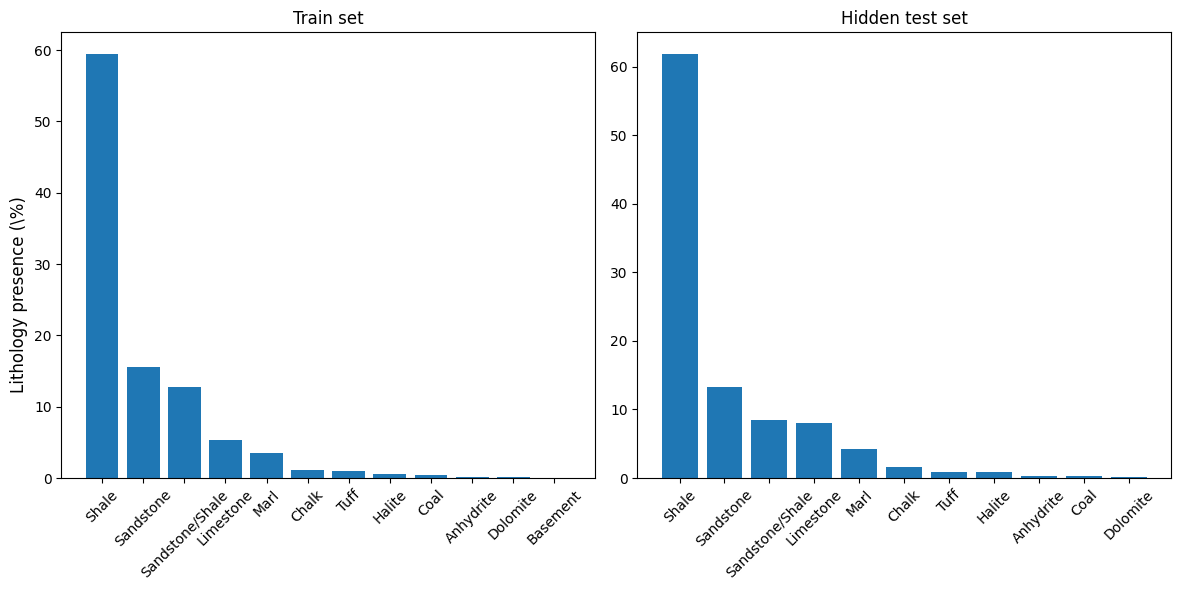

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_names = []
train_percentage = []
train_counts = train_df['CLASS'].value_counts()

test_names = []
test_percentage = []
test_counts = test_df['CLASS'].value_counts()

for item in train_counts.items():
    train_names.append(lithology_keys[item[0]])
    train_percentage.append(100 * float(item[1])/train_df.shape[0])

for item in test_counts.items():
    test_names.append(lithology_keys[item[0]])
    test_percentage.append(100 * float(item[1])/test_df.shape[0])

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].set_title('Train set')
ax[0].bar(x=np.arange(len(train_names)), height=train_percentage)
ax[0].set_xticks(np.arange(len(train_names)))
ax[0].set_xticklabels(train_names, rotation=45)

ax[1].set_title('Hidden test set')
ax[1].bar(x=np.arange(len(test_names)), height=test_percentage)
ax[1].set_xticks(np.arange(len(test_names)))
ax[1].set_xticklabels(test_names, rotation=45)

fig.supylabel('Lithology presence (\%)')
fig.tight_layout()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FORCE(Dataset):
    def __init__(self, dataframe, window_size = 50):
        # Convert dataframe to NumPy array
        self.data_array = dataframe.drop(columns=['WELL']).values
        self.groups = dataframe['WELL'].values
        self.window_size = window_size
        self.group_indices = self.compute_group_indices()

    def __len__(self):
        return len(self.group_indices)

    def __getitem__(self, idx):

        group_idx, data_idx = self.group_indices[idx]
        sequence_ = self.data_array[data_idx:data_idx+self.window_size]
        sequence = sequence_[:,:-1]
        label = sequence_[:,-1]

        sequence = (sequence - sequence.mean())/sequence.std()

        return torch.from_numpy(sequence).to(torch.float32), torch.from_numpy(label).to(torch.long)

    def compute_group_indices(self):
        unique_groups, group_counts = np.unique(self.groups, return_counts=True)
        group_indices = []
        start_idx = 0
        for group, count in zip(unique_groups, group_counts):
            end_idx = start_idx + count - self.window_size - 1
            indices = [(i, idx) for i, idx in enumerate(range(start_idx, end_idx))]
            group_indices.extend(indices)
            start_idx = end_idx
        return group_indices

In [ ]:
window_size = 50
train_dataset = FORCE(train_df, window_size)
test_dataset = FORCE(test_df, window_size)

print('Número de dados de treino:', len(train_dataset))
print('Número de dados de teste:', len(test_dataset))

Número de dados de treino: 716360
Número de dados de teste: 95329


In [ ]:
X, y = train_dataset[0]
print('Dimensão das features:', X.shape)
print('Dimensão das anotações:', y.shape)

Dimensão das features: torch.Size([50, 4])
Dimensão das anotações: torch.Size([50])


### Treinamento

2. Implemente o modelo `LithologyTransformer`.

In [ ]:
import math

class PositionalEncoding(nn.Module):
    """ Código baseado de https://pytorch.org/tutorials/beginner/transformer_tutorial.html """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # fazendo com que "pe" seja um buffer (variável não treinável)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

class LithologyTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead,
                 dim_feedforward, norm_first, num_encoder_layers, num_decoder_layers):
        super().__init__()

        self.encoder_embedding = nn.Linear(input_size, d_model)
        self.decoder_embedding = nn.Embedding(1+output_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, activation='gelu', batch_first=True, norm_first=norm_first)

        self.classifier = nn.Linear(d_model, output_size)

    def forward(self, src, tgt):
        src = self.positional_encoding(self.encoder_embedding(src))
        tgt = self.positional_encoding(self.decoder_embedding(tgt))

        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        outputs = self.transformer(src, tgt, tgt_mask=tgt_mask)

        return outputs

In [ ]:
import torch.optim as optim

d_model = 8
batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

model = LithologyTransformer(input_size=4, output_size=12, d_model=d_model, nhead=4, dim_feedforward=16,
                             norm_first=False, num_encoder_layers=1, num_decoder_layers=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print('Número de parâmetros do nosso modelo:', n_params)

print('\nComponentes do modelo final:')
print(model)

Número de parâmetros do nosso modelo: 6124

Componentes do modelo final:
LithologyModel(
  (encoder_embedding): Linear(in_features=4, out_features=16, bias=True)
  (decoder_embedding): Embedding(13, 16)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=32, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    

In [ ]:
from tqdm.notebook import tqdm

def train_epoch(model, dataloader, optimizer, criterion):
    epoch_loss = 0

    model.train()
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X = X.to(device)
        y = y.to(device)

        # Shiftando o target para a direita (inserção do token <sos>)
        sos = torch.full((batch_size, 1), fill_value=12).to(device)
        tgt = torch.cat([sos, y], dim=1)

        outputs = model(X, tgt)
        outputs = outputs[:, :-1]

        optimizer.zero_grad()
        loss = criterion(outputs.transpose(1, 2), y)  # a loss function espera que a saída do modelo seja (batch_size, out_size, seq_lengh)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (batch + 1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Batch [{batch+1}/{len(dataloader)}] -> batch loss: {loss.item():.5f}')

    epoch_loss /= len(dataloader)
    return epoch_loss

In [ ]:
num_epochs = 1
for epoch in range(1, num_epochs + 1):
    epoch_loss = train_epoch(model, train_dataloader, optimizer, criterion)

    print(f'Epoch [{epoch}/{num_epochs}] -> mean epoch loss: {epoch_loss:.5f}')

  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [1/1], Batch [100/699] -> batch loss: 0.62843
Epoch [1/1], Batch [200/699] -> batch loss: 0.39159
Epoch [1/1], Batch [300/699] -> batch loss: 0.32217
Epoch [1/1], Batch [400/699] -> batch loss: 0.29930
Epoch [1/1], Batch [500/699] -> batch loss: 0.26858
Epoch [1/1], Batch [600/699] -> batch loss: 0.23993
Epoch [1/1] -> mean epoch loss: 0.46057


### Avaliando a performance da rede em dados de teste

In [ ]:
def evaluate(model, dataloader, criterion):
    total_loss = 0.0

    predictions = torch.zeros(len(dataloader), batch_size, window_size).to(device)
    labels = torch.zeros_like(predictions)

    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X = X.to(device)
            y = y.to(device)

            preds = torch.full((batch_size, 1), fill_value=12).to(device)
            for i in range(X.shape[1]):
                outputs = model(X, preds)
                last_pred = outputs.argmax(dim=-1)[:, -1].unsqueeze(1)

                preds = torch.cat([preds, last_pred], dim=1)

            loss = criterion(outputs.transpose(1, 2), y)  # a loss function espera que a saída do modelo seja (batch_size, out_size, seq_lengh)
            total_loss += loss.item()

            predictions[batch] = outputs.argmax(dim=-1)
            labels[batch] = y

    total_loss /= len(dataloader)
    return total_loss, predictions, labels

In [ ]:
total_loss, predictions, labels = evaluate(model, test_dataloader, criterion)

print(f'Mean hidden test loss: {total_loss:.5f}')

  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1187: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Mean hidden test loss: 2.13200


In [ ]:
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix

acc = Accuracy(task = 'multiclass', num_classes = 12).to(device)
prec = Precision(task = 'multiclass', average='macro', num_classes = 12).to(device)
recall = Recall(task = 'multiclass', average='macro', num_classes = 12).to(device)

print(f'Acurácia: {(100*acc(labels, predictions)):.2f}%')
print(f'Precisão: {(100*prec(labels, predictions)):.2f}%')
print(f'Recall: {(100*recall(labels, predictions)):.2f}%')

Acurácia: 62.23%
Precisão: 9.09%
Recall: 5.66%


Computando uma matriz de confusão para verificarmos a qualidade do nosso modelo nos dados de teste.

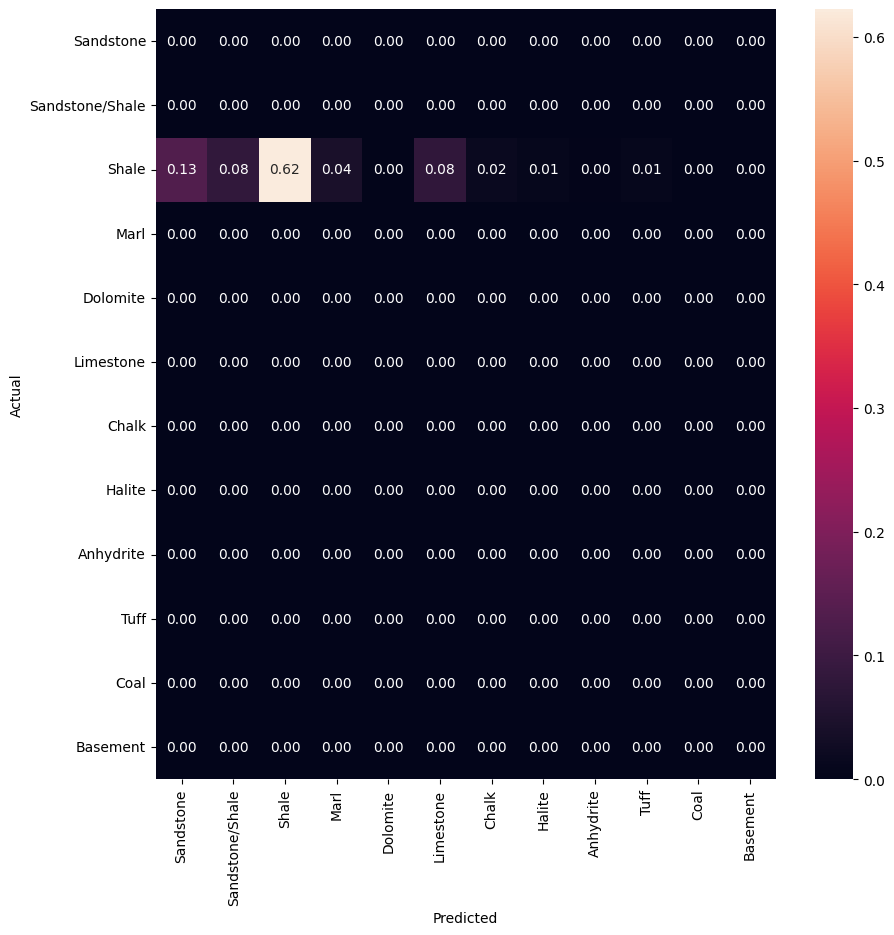

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix = ConfusionMatrix(task = 'multiclass', num_classes = 12).to(device)
cm = confusion_matrix(labels, predictions).cpu()
cm = (cm.float() / cm.sum(axis=1)[:, np.newaxis]).nan_to_num()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=lithology_keys.values(), yticklabels=lithology_keys.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)